#  TASK 2 OF THE ML TASK

** i am using groq api for this task**

#INSTALL ALL THE NECESSARY MODULES

In [481]:
!pip install langgraph langchain langchain_groq requests

In [482]:
from typing import Annotated, Sequence, TypedDict
from dotenv import load_dotenv  
from langchain_core.messages import BaseMessage # The foundational class for all message types in LangGraph
from langchain_core.messages import ToolMessage # Passes data back to LLM after it calls a tool such as the content and the tool_call_id
from langchain_core.messages import SystemMessage # Message for providing instructions to the LLM
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from typing import TypedDict, List
import requests
from datetime import datetime, timezone
import os

In [483]:
import os
os.environ["LANGCHAIN_API_KEY"] = "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"
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]="CourseLanggraph"

In [484]:
from langchain_groq import ChatGroq

In [485]:
llm=ChatGroq(groq_api_key="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",model_name="Gemma2-9b-It")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000211947A3140>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000211948FDFD0>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********'))

# CREATE A STATE FUNCTION

In [486]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

#DEFINE A CALCULATOR TOOL FROM IMPORTED MODULES

In [487]:
from langchain_core.tools import tool
from math import sin, cos, tan

@tool
def calculator(expression: str) -> str:
    """Evaluates a mathematical expression following BODMAS rules."""
    try:
        # Safely evaluate the expression with restricted globals and locals
        result = eval(expression, {"__builtins__": {}}, {"sin": sin, "cos": cos, "tan": tan})
        return f"Result: {result}"
    except Exception as e:
        return f"Error: Invalid expression ({str(e)})"

#CREATE a fashion recommendation tool

In [488]:

@tool
def fashion_recommender(location: str) -> str:
    """Returns fashion trends for a given location."""
    trends = {
        "tokyo": "Streetwear with bold colors and layered outfits",
        "new york": "Minimalist chic with neutral tones",
        "paris": "Elegant dresses and tailored suits"
    }
    return trends.get(location.lower(), "No trend data available for this location")

#  CREATE A WHEATER TOOL

In [489]:
import requests
import json
from datetime import datetime

class WeatherExtractor:
    def __init__(self, api_key):
        self.api_key = api_key
        self.base_url = "https://api.openweathermap.org/data/2.5/weather"

    def fetch_weather(self, location):
        
        params = {
            "q": location,
            "appid": self.api_key,
            "units": "metric"  
        }

       
        try:
            response = requests.get(self.base_url, params=params)
            response.raise_for_status()  
            weather_data = response.json()

            
            if weather_data.get("cod") != 200:
                return {"error": weather_data.get("message", "Unable to fetch weather data")}

            main = weather_data.get("main", {})
            weather = weather_data.get("weather", [{}])[0]
            wind = weather_data.get("wind", {})
            sys = weather_data.get("sys", {})

           
            result = {
                "location": f"{weather_data.get('name', 'Unknown')}, {sys.get('country', 'Unknown')}",
                "temperature": main.get("temp", "N/A"),
                "weather_description": weather.get("description", "N/A").capitalize(),
             "humidity": main.get("humidity", "N/A"),
                "wind_speed": wind.get("speed", "N/A"),
                "pressure": main.get("pressure", "N/A"),
                "timestamp": datetime.utcfromtimestamp(weather_data.get("dt", 0)).strftime('%Y-%m-%d %H:%M:%S UTC')
            }
            return result

        except requests.exceptions.RequestException as e:
            return {"error": f"Failed to fetch weather data: {str(e)}"}

    def display_weather(self, weather_data):
        if "error" in weather_data:
            print(f"Error: {weather_data['error']}")
        else:
            print(f"Current Weather in {weather_data['location']}:")
            print(f"Temperature: {weather_data['temperature']}°C")
            print(f"Condition: {weather_data['weather_description']}")
            print(f"Humidity: {weather_data['humidity']}%")
            print(f"Wind Speed: {weather_data['wind_speed']} m/s")
            print(f"Pressure: {weather_data['pressure']} hPa")
            print(f"Data Fetched At: {weather_data['timestamp']}")

@tool
def weather_extractor(location: str) -> str:
    """Fetches current weather for a given location using OpenWeatherMap API.""" #doc tag
    api_key = "a6716270c6acf61ed82cbc850809c582"  
    weather_tool = WeatherExtractor(api_key)
    weather_data = weather_tool.fetch_weather(location)
    return weather_tool.display_weather(weather_data)



In [490]:
tools = [calculator,fashion_recommender,weather_extractor]

# BINDING THE TOOLS IS IMPORTANT

In [491]:
model = ChatGroq(model = "Gemma2-9b-It",api_key="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").bind_tools(tools)

**create a state function to store messages**

In [492]:

class State(TypedDict):
    messages: List[HumanMessage | AIMessage | ToolMessage]

def chatbot_node(state):
    query = state["messages"][-1].content  # Get the latest user query
    prompt = ChatPromptTemplate.from_template("Answer the query: {query}")
    chain = prompt | llm_with_tools
    response = chain.invoke({"query": query})
    
  
    new_messages = state["messages"]
    
  #if response had a tool call
    if hasattr(response, "tool_calls") and response.tool_calls:
        tool_call = response.tool_calls[0]
        if tool_call["name"] == "weather_extractor":
            location = tool_call["args"]["location"]
            result = weather_extractor.invoke(location)
            # Add ToolMessage with the correct tool call ID
            new_messages += [
                AIMessage(content="", tool_calls=[tool_call]),
                ToolMessage(content=result, tool_call_id=tool_call["id"], name="weather_extractor"),
                AIMessage(content=result)
            ]
    else:
        new_messages += [AIMessage(content=response.content)]
    
    return {"messages": new_messages}


In [493]:
# Build LangGraph workflow
workflow = StateGraph(State)
workflow.add_node("chatbot", chatbot_node)
workflow.set_entry_point("chatbot")
workflow.add_edge("chatbot", END)

**craeting the model**

In [494]:
def model_call(state:AgentState) -> AgentState:
    system_prompt = SystemMessage(content=
        "You are my AI assistant, please answer my query to the best of your ability."
    )
    response = model.invoke([system_prompt] + state["messages"])
    return {"messages": [response]}

In [495]:
def should_continue(state: AgentState): 
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls: 
        return "end"
    else:
        return "continue"

In [500]:
graph = StateGraph(AgentState)
graph.add_node("our_agent", model_call)


tool_node = ToolNode(tools=tools)
graph.add_node("tools", tool_node)

In [501]:
graph.set_entry_point("our_agent")

In [502]:
graph.add_conditional_edges(
    "our_agent",
    should_continue,
    {
        "continue": "tools",
        "end": END,
    },
)

graph.add_edge("tools", "our_agent")

app = graph.compile()

# THE GRAPH OF THE CHATBOT

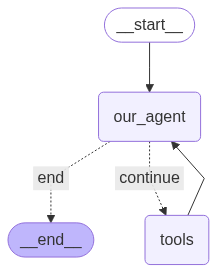

In [503]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [504]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [505]:
inputs = {"messages": [("user", "whats the weather in tokyo ")]}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

whats the weather in tokyo 
================================== Ai Message ==================================
Tool Calls:
  weather_extractor (call_tv1k)
 Call ID: call_tv1k
  Args:
    location: Tokyo
Current Weather in Tokyo, JP:
Temperature: 15.14°C
Condition: Heavy intensity rain
Humidity: 93%
Wind Speed: 4.12 m/s
Pressure: 1005 hPa
Data Fetched At: 2025-05-24 17:51:44 UTC


C:\Users\chara\AppData\Local\Temp\ipykernel_9572\2715821610.py:41: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(weather_data.get("dt", 0)).strftime('%Y-%m-%d %H:%M:%S UTC')


================================= Tool Message =================================
Name: weather_extractor

null
================================== Ai Message ==================================

I am sorry, but I do not have access to past conversation history. Please provide me with the necessary context or information.


In [506]:
#NOW its time to add memory to it

In [527]:
from typing import TypedDict, List, Union

In [563]:
# Import required libraries
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END, START
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from typing import TypedDict, List
import requests
from datetime import datetime, timezone
import os

In [561]:
inputs = {"messages": [("user", "whats the weather in tokyo ")]}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

whats the weather in tokyo 
================================== Ai Message ==================================
Tool Calls:
  weather_extractor (call_gmqt)
 Call ID: call_gmqt
  Args:
    location: tokyo


C:\Users\chara\AppData\Local\Temp\ipykernel_9572\2715821610.py:41: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "timestamp": datetime.utcfromtimestamp(weather_data.get("dt", 0)).strftime('%Y-%m-%d %H:%M:%S UTC')


Current Weather in Tokyo, JP:
Temperature: 15.14°C
Condition: Heavy intensity rain
Humidity: 93%
Wind Speed: 4.12 m/s
Pressure: 1005 hPa
Data Fetched At: 2025-05-24 18:08:29 UTC
================================= Tool Message =================================
Name: weather_extractor

null
================================== Ai Message ==================================

I apologize, I don't have access to past conversations or tool results.  Could you please try calling the weather_extractor tool again?
